# WIPRO TIME SERIERS - ANOMALY DETECTION AND SEQUENCE PREDICTION

**Requirements**

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

USE_CUDA = torch.cuda.is_available()

env: CUDA_VISIBLE_DEVICES=0


# Load NASA data 

[from dataset readme]
The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1)  unit number  
2)  time, in cycles  
3)  operational setting 1  
4)  operational setting 2  
5)  operational setting 3  
6)  sensor measurement  1  
7)  sensor measurement  2  
...  
26) sensor measurement  26  


In [2]:
file_path = './nasa_data/train_FD001.txt'
header_names = ['unit number', 'time in cycles']  + ['operational setting %d'%i for i in range(1, 4)] + [ 'sensor measurement %d'%i for i in range(1, 24)]
df_train = pd.read_csv(file_path, sep=' ', header=None, names=header_names)
df_train = df_train.dropna(axis=1, how='all')
df_train.head()

,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
file_path = './nasa_data/test_FD001.txt'
header_names = ['unit number', 'time in cycles']  + ['operational setting %d'%i for i in range(1, 4)] + [ 'sensor measurement %d'%i for i in range(1, 24)]
df_test = pd.read_csv(file_path, sep=' ', header=None, names=header_names)
df_test = df_test.dropna(axis=1, how='all')
df_test.head()

,unit number,time in cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [4]:
def get_train_test_data(df_train, df_test):
    
    amount_of_units_tot = df_train['unit number'].max()
    amount_of_units_tst = 2
    amunt_of_units_tr = amount_of_units_tot - amount_of_units_tst
    
    X_tr = []
    X_tst = []
    
    me = []
    std = []
    for idx in range(1, amount_of_units_tot + 1):
        me = df_train[df_train['unit number'] == idx].iloc[:, 2:].mean()
        std =  df_train[df_train['unit number'] == idx].iloc[:, 2:].std()
        group_tr = (df_train[df_train['unit number'] == idx].iloc[:, 2:] - me) / (std + 1e-12)
        
        me = df_test[df_test['unit number'] == idx].iloc[:, 2:].mean()
        std =  df_test[df_test['unit number'] == idx].iloc[:, 2:].std()
        group_ts = (df_test[df_test['unit number'] == idx].iloc[:, 2:] - me) / (std + 1e-12)
        
        X_tst.append(group_ts.as_matrix())
        X_tr.append(group_tr.as_matrix())
        
    return X_tr, X_tst

Plot test example of sensors

First 50 cycles


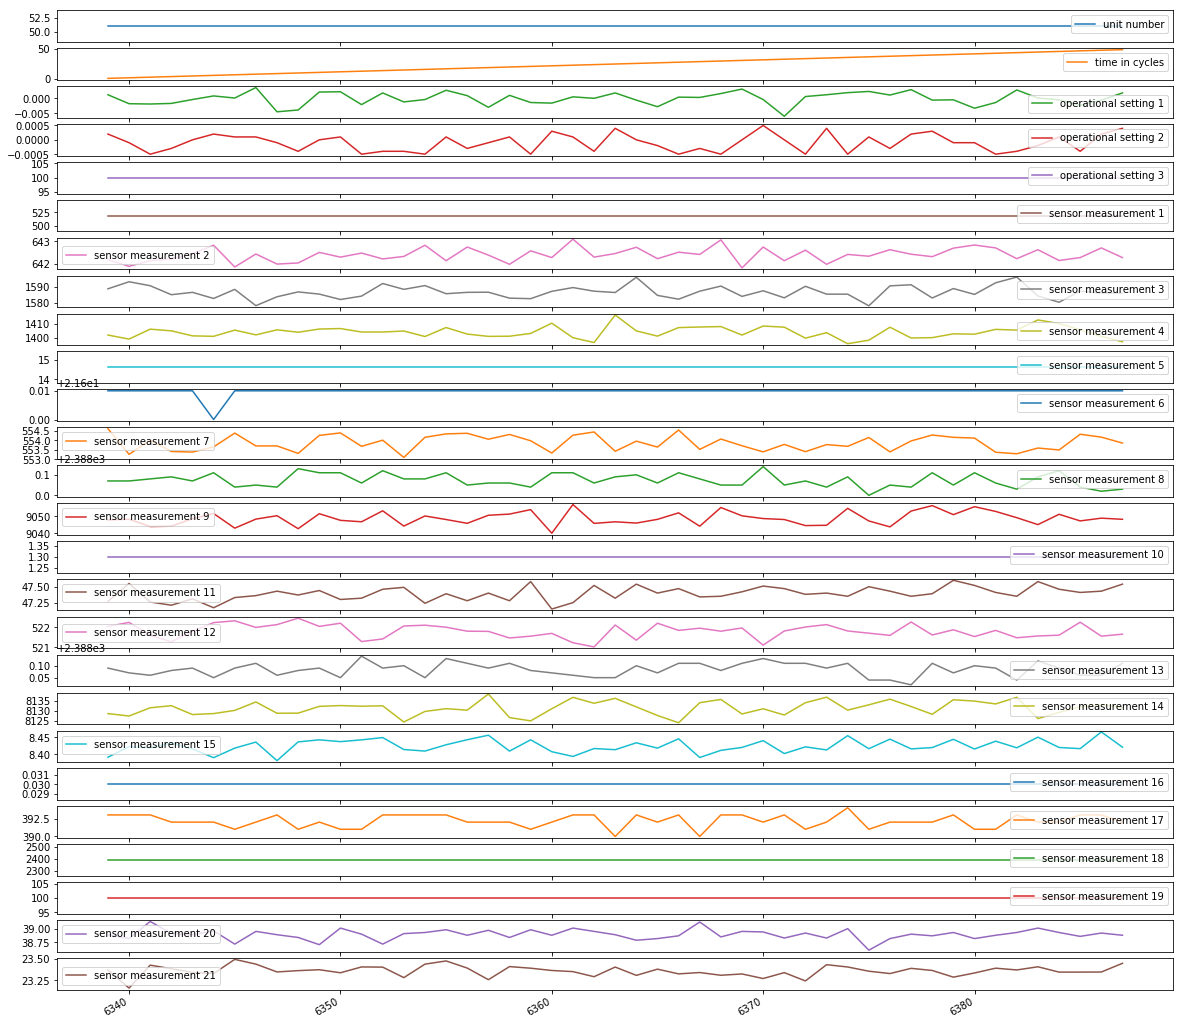

In [5]:
unit = np.random.randint(1, df_test['unit number'].max())
window_sz = 50

plot_example = df_test[(df_test['unit number'] == unit) &  (df_test['time in cycles'] < window_sz) ]
print('First 50 cycles')
ax = plot_example.plot(subplots=True, sharex=True, figsize=(20,20))

Last 50 cycles


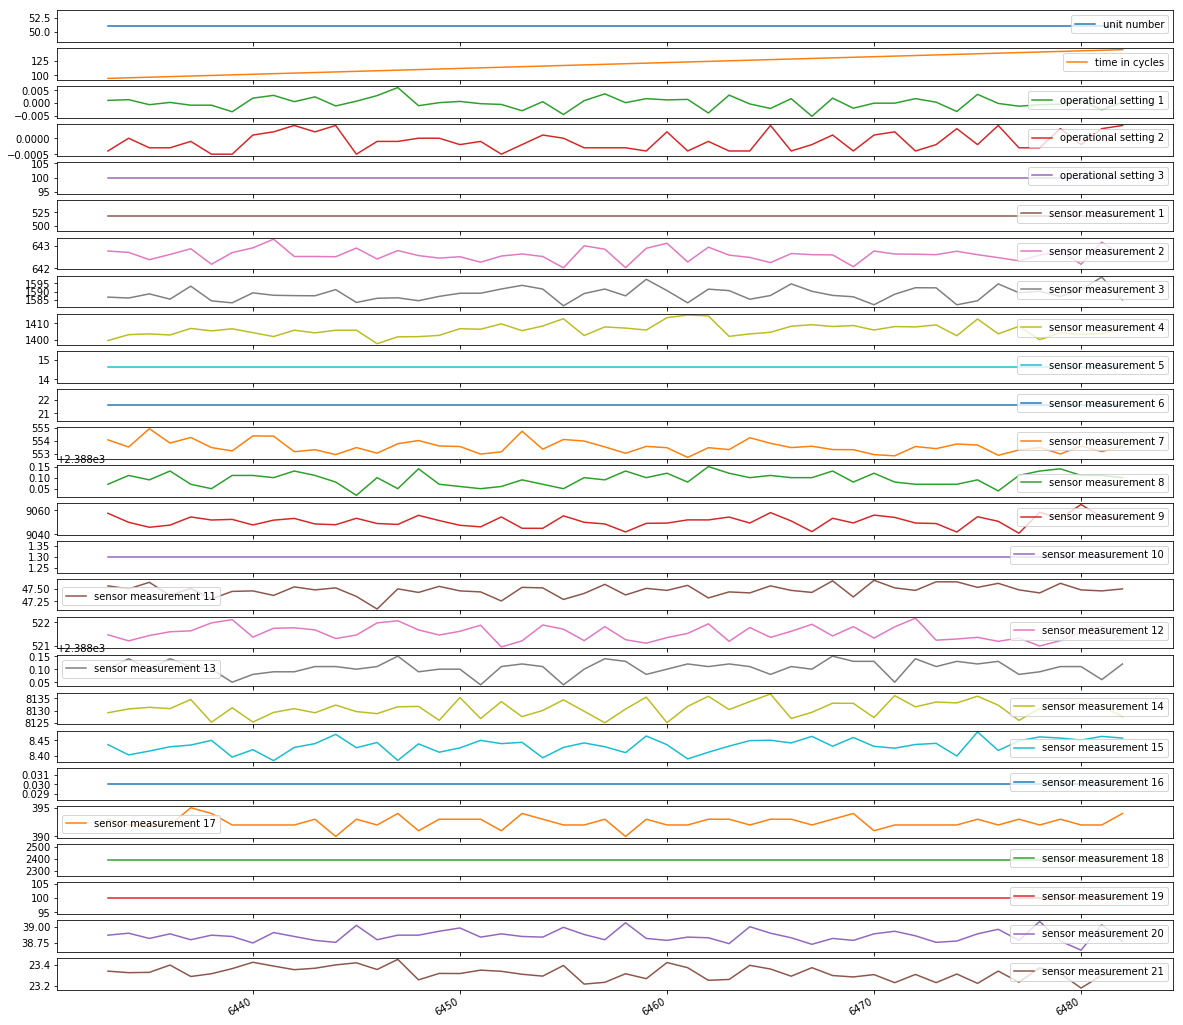

In [6]:
amount_of_cycles = df_test[(df_test['unit number'] == unit)]['time in cycles'].max()
plot_example = df_test[(df_test['unit number'] == unit) &  (amount_of_cycles - window_sz < df_test['time in cycles']) ]
print('Last 50 cycles')
ax = plot_example.plot(subplots=True, sharex=True, figsize=(20,20))

#  Recurrent anttention based model

The idea being learn the sequential dependencys and structure via gated rnn,
and to learn spatial structure and similarity via attention mechanism. 

The Attention used in this case is inspired by https://arxiv.org/pdf/1508.04025.pdf
Where the context vector is appended to final hiddent state and are passed to output layer.
This differs to the standerd case where context is appended to input of the reccurent cell.

The RNN sequence is inspired by https://arxiv.org/pdf/1308.0850.pdf
Where LSTM based models are used for pedicting next time step.

The code is mostly based on code found here:
http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [7]:
class TrainBatch():
    
    def __init__(self, data, batch_sz, window_sz):
        self._data = data
        self._batch_sz = batch_sz
        self._window_sz = window_sz
        self._input_sz = data[0].shape[-1]
        self._seq_len = [x.shape[0] for x in self._data]
        self._curr_batch = None
        
    def next_batch(self):
        """
        return:batch[(batch_size,seq_len,input_size)]
        """
        batch = np.empty(shape=[self._batch_sz, self._window_sz, self._input_sz]) 
        amount_of_units = len(self._data)
        choose_units = np.random.choice(amount_of_units, self._window_sz)
    
        for id, unit_id in zip(range(self._batch_sz), choose_units):
            w_start_id = np.random.randint(0, self._seq_len[unit_id] - self._window_sz)
            unit = self._data[unit_id][w_start_id:w_start_id+self._window_sz, :] # for unit get seq of window sz
            batch[id,...] = unit
        batch = Variable(torch.from_numpy(batch.astype('float32')), requires_grad=False)
        if USE_CUDA:
            batch = batch.cuda()
        self._curr_data = batch
        
        return batch   

** Recurrent model for capturing sequential information**

In [8]:
class SequencePredRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(SequencePredRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=False)

    def forward(self, inputs, hidden):
        output = inputs
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

** Attention model utilize reccurnt ouputs and their spatial similarity for predicting next time step**

In [9]:
class AttendAndPredict(nn.Module):
    """Attention nn module that is responsible for computing the alignment scores."""

    def __init__(self, method, hidden_size, output_size):
        super(AttendAndPredict, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Define layers
        if self.method == 'general':
            self.attention = nn.Linear(self.hidden_size, self.hidden_size)
        elif self.method == 'concat':
            self.attention = nn.Linear(self.hidden_size * 2, self.hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, self.hidden_size))
            
        self.fc_out = nn.Linear(self.hidden_size * 2, self.output_size)
        
        

    def forward(self, hidden, M):
        """Attend over N rnn sequence prediction outputs till time t-1 (t-2-N...t-1).
        
        After creating variables to store the attention energies, calculate their 
        values for each encoder output and return the normalized values.
        
        Args:
            M(mem_size,batch,input size): memory of which to attend over.
            hidden(1, batch, input size): hidden state.
            
        Returns:
             Normalized (0..1) energy values, re-sized to 1 x 1 x seq_len
        """
        
        mem_size = M.size()[0]
        batch_size = M.size()[1]
        
        # convert to batch first
        M = M.permute(1,0,2)
        hidden = hidden.permute(1,2,0)

        energies = self._score(hidden, M)
        a = F.softmax(energies, dim=1)
        c = a.permute(0,2,1).bmm(M)
        next_timestep_prediction = self.fc_out(torch.cat((c.squeeze(1), hidden.squeeze(2)), 1))
        
        return next_timestep_prediction, a
        
    def _score(self, hidden, M):
        """
        Calculate the relevance of a particular encoder output in respect to the decoder hidden.
        Args:
            hidden: decoder hidden output used for condition.
            M(batch,seq_len,input_size): memory of which to attend over.
            hidden(1, batch, input size): hidden state.
        """

        if self.method == 'dot':
            # TODO: Not tested
            energy = hidden.dot(M)
        elif self.method == 'general':
            energy = self.attention(M)
            energy = torch.bmm(energy, hidden)#hidden.dot(energy)
        elif self.method == 'concat':
            # TODO: Not tested
            energy = self.attention(torch.cat((hidden, M), 1))
            energy = self.other.dor(energy)
        return energy



In [10]:
class SeqRnnAttnAndPred(nn.Module):
    """
    SequenceAttnPred - Recurrent Atteniton based model for predicting next time step.
    """
    def __init__(self, input_size, hidden_size, output_size, batch_size,
                 rnn_layers=1, atnn_method='general', memory_size=-1):
        """
        args:
        input_size: size of elemnt of sequnece.
        hidden_size: size of hidden state of RNN (same as output if only 1 RNN).
        output_size: size of output tensor.
        rnn_layers: amount of stacked RNN's (see any basic seq2seq paper).
        atnn_method: type of attention to use.
        memory_size: amount of rnn output's to aggregate and attend over.
        """
        super(SeqRnnAttnAndPred, self).__init__()
        self._rnn_layer = SequencePredRNN(input_size, hidden_size, rnn_layers)
        self._atnn_layer = AttendAndPredict(atnn_method, hidden_size, output_size)
        self._memory_size = memory_size
        
    def forward(self, inputs, hidden):
        """
        args:
        inputs(seq_len,batch,input_len): input sequence predict seq_len + 1
        """
        seq_len = inputs.size()[0]
        
        # in case of 1 rnn layer output == hidden.
        seqrnn_output, hidden = self._rnn_layer(inputs, hidden)
        self.memory = seqrnn_output[-self._memory_size-1:-1]
        hidden_t = seqrnn_output[-1].unsqueeze(0)
        outputs, alignment = self._atnn_layer(hidden_t, self.memory)
        return outputs, alignment
    
    def init_hidden(self, batch_size):
        hidden = Variable(torch.zeros(1, batch_size, self._rnn_layer.hidden_size))
        hidden = hidden.cuda() if USE_CUDA else hidden
        return hidden
        
   

** Helper functions **

In [11]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

** Training procedure**

Run model on data

In [12]:
def run(input_seq, model, criterion, batch_size, train=False, optimizer=None):
    """
    Train for a given sequence batch size.
    Args:
    input_seq(batch_size,seq_len,input_size): tensor containin sequences.
    model: input model - batch is first dim.
    criterion: distance measure i.e. l1, l2 etc.
    optimizer: GD, ADAM etc.
    """ 
    hidden = model.init_hidden(batch_size)
    
    input_seq = input_seq.transpose(0, 1)
    preds, alignment = model(input_seq[:-1], hidden)
    loss = criterion(preds, input_seq[-1])
    
    if train:
        model.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss.data[0], preds
        


This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

Full train procedure

In [13]:
def trainIters(train_batch, test_data, model, n_iters, print_every=500, plot_every=1000, learning_rate=0.01):
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    test_losses = []

    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss().cuda()
  

    for iter in range(1, n_iters):
        
        curr_batch = train_batch.next_batch() 
        loss, _ = run(curr_batch, model, criterion, train_batch._batch_sz, True, optimizer)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            test_losses.append(evaluate(test_data, model, train_batch._window_sz))
            print('%s (%d : %d%%) %.4f test error %.4f' % (timeSince(start, float(iter) / n_iters),
                                         iter, n_iters, print_loss_avg, test_losses[-1]))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        
    show_plot(plot_losses, test_losses)


In [14]:
def show_plot(train, test):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(range(len(train)), train, range(len(test)), test)

In [15]:
def evaluate(test_data, model, window_sz):
    
    loss_total = 0  # Reset every print_every
    test_count = 0

    criterion = nn.MSELoss().cuda()
    
    for seq in test_data:
        seq_len = seq.shape[0]
        for i in range(seq_len - window_sz):
            test_seq = seq[i: i + window_sz]
            test_seq = Variable(torch.from_numpy(test_seq.astype('float32')), requires_grad=False).unsqueeze(0)
            if USE_CUDA:
                test_seq = test_seq.cuda()
            loss, _ = run(test_seq, model, criterion, 1, False)
            loss_total += loss
            test_count += 1
    return loss_total / test_count
    

** Main Entry Point **

Load data and set hyperparams

In [16]:
data_train, data_test = get_train_test_data(df_train, df_test)
print("train size: %d test size: %d"%(len(data_train), len(data_test)))

input_size = data_train[0].shape[-1]
output_size = input_size
batch_size = 64
hidden_size = input_size # disregarded when rnn_layers=1
rnn_layers = 1
memory_size = 30
window_size = 50 # what is the window we train over


train size: 100 test size: 100


In [ ]:

model = SeqRnnAttnAndPred(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
                          batch_size=batch_size, rnn_layers=rnn_layers, atnn_method='general',
                          memory_size=memory_size)

if USE_CUDA:
    model = model.cuda()
    
train_batch = TrainBatch(data_train, batch_size, window_size)

trainIters(train_batch, data_test, model, 500000, print_every=5000)

torch.save(model.state_dict(), "./saved_models/pred_nasa_seq")

2m 40s (- 265m 18s) (5000 : 500000%) 0.2771 test error 0.5281
5m 20s (- 261m 33s) (10000 : 500000%) 0.2460 test error 0.5240
7m 59s (- 258m 39s) (15000 : 500000%) 0.2422 test error 0.5216
10m 39s (- 255m 57s) (20000 : 500000%) 0.2409 test error 0.5201
13m 19s (- 253m 16s) (25000 : 500000%) 0.2402 test error 0.5191
15m 57s (- 250m 7s) (30000 : 500000%) 0.2392 test error 0.5185


** Run Evaluation **

In [ ]:
model = SeqRnnAttnAndPred(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
                          batch_size=1, rnn_layers=rnn_layers, atnn_method='general',
                          memory_size=memory_size)
if USE_CUDA:
    model = model.cuda()
    
model.load_state_dict(torch.load("./saved_models/pred_nasa_seq"))


evaluate(data_test, model)